In [ ]:
!python -V
# to start MLFlow:  mlflow ui --backend-store-uri sqlite:///mlflow.db

# Also: mlflow server \
#  --backend-store-uri sqlite:///mlflow.db \
#  --default-artifact-root ./mlruns \
#  --host 127.0.0.1 \
#  --port 5001

# https://stackoverflow.com/questions/77668718/conda-environment-doubly-activated

Python 3.13.2


In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1747521064076, experiment_id='2', last_update_time=1747521064076, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [32]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [33]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_2318/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2318/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


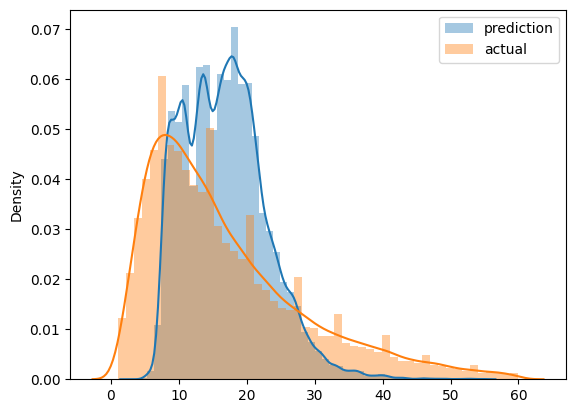

In [34]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [35]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [36]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [37]:
len(df_train), len(df_val)

(73908, 61921)

In [38]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [39]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'eyram')

    # Super simple data versioning, but can do better (DVC?)
    mlflow.log_param('train-data-path','./data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path','./data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

In [42]:
import xgboost as xgb

In [43]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [44]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    #with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(params)
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [45]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:11:45] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.08729                          
[1]	validation-rmse:10.17351                          
[2]	validation-rmse:9.43393                           
[3]	validation-rmse:8.84206                           
[4]	validation-rmse:8.36532                           
[5]	validation-rmse:7.98958                           
[6]	validation-rmse:7.70017                           
[7]	validation-rmse:7.46714                           
[8]	validation-rmse:7.28687                           
[9]	validation-rmse:7.14498                           
[10]	validation-rmse:7.03123                          
[11]	validation-rmse:6.94222                          
  0%|          | 0/50 [00:19<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [46]:
params = {
    'learning_rate': 0.2475583972189289,
    'max_depth': 57,
    'min_child_weight': 1.8579095024794385,
    'objective': 'reg:linear',
    'reg_alpha': 0.021331276771262772,
    'reg_lambda': 0.20351318290492154,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2025/05/27 00:12:08 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:12:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.25672
[1]	validation-rmse:8.93247
[2]	validation-rmse:8.05978
[3]	validation-rmse:7.50260
[4]	validation-rmse:7.14488
[5]	validation-rmse:6.91857
[6]	validation-rmse:6.76852
[7]	validation-rmse:6.67225
[8]	validation-rmse:6.60962
[9]	validation-rmse:6.56628
[10]	validation-rmse:6.53210
[11]	validation-rmse:6.50791
[12]	validation-rmse:6.49083
[13]	validation-rmse:6.47782
[14]	validation-rmse:6.46797
[15]	validation-rmse:6.45970
[16]	validation-rmse:6.45330
[17]	validation-rmse:6.44925
[18]	validation-rmse:6.44637
[19]	validation-rmse:6.44388
[20]	validation-rmse:6.44220
[21]	validation-rmse:6.43941
[22]	validation-rmse:6.43791
[23]	validation-rmse:6.43501
[24]	validation-rmse:6.43260
[25]	validation-rmse:6.42956
[26]	validation-rmse:6.42763
[27]	validation-rmse:6.42475
[28]	validation-rmse:6.42296
[29]	validation-rmse:6.42099
[30]	validation-rmse:6.41908
[31]	validation-rmse:6.41632
[32]	validation-rmse:6.41446
[33]	validation-rmse:6.41180
[34]	validation-rmse:6.

2025/05/27 00:13:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [00:13:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/27 00:13:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID b56ef9ae4ac34934afdc7dac6505bb8e. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'learning_rate\', \'old_value\': \'0.14206549611282498\', \'new_value\': \'0.2475583972189289\'}, {\'key\': \'max_depth\', \'old_value\': \'49\', \'new_value\':

In [52]:
mlflow.end_run()

with mlflow.start_run():

    train = xgb.DMatrix(X_train, label = y_train)
    valid = xgb.DMatrix(X_val, label = y_val)


    best_params = {
    'learning_rate': 0.14206549611282498,
    'max_depth': 49,
    'min_child_weight': 0.49028,
    'objective': 'reg:linear',
    'reg_alpha': 0.008233,
    'reg_lambda': 0.03588,
    'seed': 42
}

    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")


    mlflow.xgboost.log_model(booster, artifact_path= 'models_mlflow')

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:42:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:11.08729
[1]	validation-rmse:10.17351
[2]	validation-rmse:9.43393
[3]	validation-rmse:8.84206
[4]	validation-rmse:8.36532
[5]	validation-rmse:7.98958
[6]	validation-rmse:7.70017
[7]	validation-rmse:7.46714
[8]	validation-rmse:7.28688
[9]	validation-rmse:7.14499
[10]	validation-rmse:7.03123
[11]	validation-rmse:6.94222
[12]	validation-rmse:6.87151
[13]	validation-rmse:6.81693
[14]	validation-rmse:6.76898
[15]	validation-rmse:6.73174
[16]	validation-rmse:6.70284
[17]	validation-rmse:6.67513
[18]	validation-rmse:6.65637
[19]	validation-rmse:6.63961
[20]	validation-rmse:6.62475
[21]	validation-rmse:6.61344
[22]	validation-rmse:6.60499
[23]	validation-rmse:6.59723
[24]	validation-rmse:6.59066
[25]	validation-rmse:6.58376
[26]	validation-rmse:6.57788
[27]	validation-rmse:6.57353
[28]	validation-rmse:6.56917
[29]	validation-rmse:6.56590
[30]	validation-rmse:6.56234
[31]	validation-rmse:6.55912
[32]	validation-rmse:6.55611
[33]	validation-rmse:6.55320
[34]	validation-rmse:6

2025/05/27 00:45:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [00:45:30] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.13/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [00:45:37] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/27 00:45:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
